In [1]:
import pandas as pd
from src.digital_twin.bess import BatteryEnergyStorageSystem
from src.online_learning.utils import load_from_yaml
import matplotlib.pyplot as plt
import  numpy as np

Since the batchsize used for the optimization step has 40000 samples, a signal of the same lenght is exploited to perform the analysis

In [2]:
df_ground = pd.read_csv('../../../data/ground/experiment_signals/dataset_0_cutted40000samples.csv')

In [3]:
df_ground.describe()

,Unnamed: 0,time,voltage,current,temperature
count,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000
mean,19999.50000,20389.775625,26.447981,1.295466,312.744219
std,11547.14972,11772.294392,0.824208,19.043031,4.381367
min,0.00000,0.000000,24.381471,-23.953000,299.328949
25%,9999.75000,10195.750000,25.857377,-19.520000,309.787835
50%,19999.50000,20390.500000,26.508916,3.445000,311.988319
75%,29999.25000,30584.250000,27.102616,16.690000,313.920891
max,39999.00000,40779.000000,27.993060,32.551000,325.320643


Since during the operational time of the battery the algorithm replace the current theta of the battery with a centroid of the following nominal clusters, the nominal clusters generated from the k_means are exploited

In [4]:
df_nominal_cluster_0 = pd.read_csv('../../../data/ground/nominal_cluster_kmeans/phi_0_kmeans.csv')
df_nominal_cluster_1 = pd.read_csv('../../../data/ground/nominal_cluster_kmeans/phi_1_kmeans.csv')
df_nominal_cluster_2 = pd.read_csv('../../../data/ground/nominal_cluster_kmeans/phi_2_kmeans.csv')
df_nominal_cluster_3 = pd.read_csv('../../../data/ground/nominal_cluster_kmeans/phi_3_kmeans.csv')

In [5]:
df_nominal_cluster_2.describe()

,Temp,Soc,C_1,R_0,R_1,Cluster
count,4.00,4.0,4.000000,4.000000,4.000000,4.0
mean,11.25,12.5,624.361218,0.028771,0.137798,2.0
std,2.50,25.0,1011.967976,0.009828,0.021040,0.0
min,10.00,0.0,103.544660,0.022908,0.108859,2.0
25%,10.00,0.0,105.365797,0.023435,0.128893,2.0
50%,10.00,0.0,125.933231,0.024364,0.144406,2.0
75%,11.25,12.5,644.928652,0.029700,0.153311,2.0
max,15.00,50.0,2142.033750,0.043449,0.153520,2.0


Inizialization of the Battery Object to perform the Analysis

In [6]:
battery = BatteryEnergyStorageSystem(
            models_config=[ load_from_yaml('../../../data/external/electrical_params'),
                  load_from_yaml('../../../data/external/thermal_params')],
            battery_options=load_from_yaml('../../../data/external/battery_options'),
            input_var= 'current'
        )
battery.reset()
battery.init()

Set the theta for the analysis

In [7]:
print(battery._electrical_model.r0.resistance,
             battery._electrical_model.rc.resistance,
             battery._electrical_model.rc.capacity)

0.04 0.01 10000.0


In [8]:
(battery._electrical_model.r0.resistance,
             battery._electrical_model.rc.resistance,
             battery._electrical_model.rc.capacity) = [0.04, 0.01, 10000]

In [9]:
elapsed_time = 0
dt = 1  
for k, load in enumerate(df_ground['current']):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df_ground['time'].iloc[k] - df_ground['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [10]:
results1 = battery.build_results_table()
results1 = results1['operations']
battery.reset()
battery.init()

In [11]:
(battery._electrical_model.r0.resistance,
             battery._electrical_model.rc.resistance,
             battery._electrical_model.rc.capacity) = [-0.00000000000000000000000000000000000000000000000000000004, -0.000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001,
                                                       0.0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001]

In [12]:
elapsed_time = 0
dt = 1  
for k, load in enumerate(df_ground['current']):
    elapsed_time += dt
    battery.t_series.append(elapsed_time)
    dt = df_ground['time'].iloc[k] - df_ground['time'].iloc[k - 1] if k > 0 else 1.0
    battery.step(load, dt, k)

In [13]:
results2 = battery.build_results_table()
results2 = results2['operations']

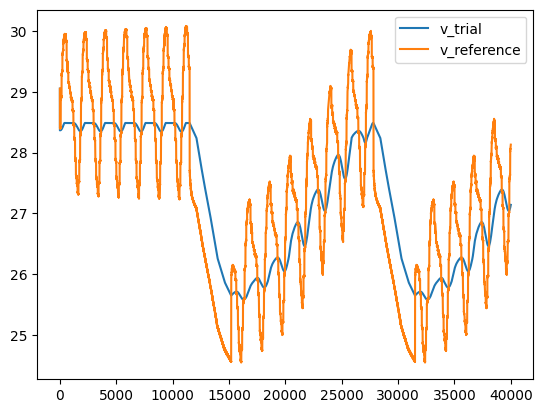

In [14]:
fig, (ax1) = plt.subplots(1, 1)
ax1.plot(results2['voltage'], label='v_trial')
ax1.plot(results1['voltage'], label='v_reference')
ax1.legend()
plt.show()